In [1]:
# Index all *.tif files in all subfolders.
from os import walk
from os.path import join,split
import fnmatch
folder_name_str = '/home/jiongyi/Documents/dna_damage/u2os_wt_60_m_post_0gr_pH2AX_53pb1_dapi_a'
tif_file_paths_str = []
search_str = '*ome.tif'
for (dir_path_str, dir_names_str, file_names_str) in walk(folder_name_str):
    for i_file_names_str in file_names_str:
        if fnmatch.fnmatch(i_file_names_str, search_str):
            tif_file_paths_str.append(join(dir_path_str, i_file_names_str))

In [2]:
from numpy import zeros, argmax, arange, mean, std, array, copy, stack, any
from scipy.stats import ttest_1samp
from skimage.filters import sobel, gaussian, threshold_otsu, threshold_minimum, threshold_isodata, rank
from skimage.morphology import erosion, reconstruction, disk, remove_small_objects
from skimage import img_as_float, img_as_uint
from skimage.io import imread, imsave
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from skimage.exposure import equalize_adapthist
import csv
from matplotlib.pyplot import figure
from seaborn import swarmplot

# Define constants.
NO_PIXELS_2_UM2 = 0.10185185185**2

# Define functions.
def extended_depth_field(z_3d):
    no_slices, no_rows, no_cols = z_3d.shape
    gauss_3d = zeros((no_slices, no_rows, no_cols))
    sobel_3d = zeros((no_slices, no_rows, no_cols))
    for i in range(no_slices):
        sobel_3d[i, :, :] = sobel(z_3d[i, :, :])
    idx_max_2d = argmax(sobel_3d, axis = 0)
    z_3d = z_3d.reshape((no_slices, -1))
    z_3d = z_3d.transpose()
    ext_depth_field_2d = z_3d[arange(len(z_3d)), idx_max_2d.ravel()]
    ext_depth_field_2d = ext_depth_field_2d.reshape((no_rows, no_cols))
    return gaussian(ext_depth_field_2d)

def tophat_reconstruction(raw_2d, struct_2d):
    eroded_2d = erosion(raw_2d, struct_2d)
    opened_2d = reconstruction(eroded_2d, raw_2d)
    tophat_2d = raw_2d - opened_2d
    return tophat_2d

def segment_puncta(tif_file_path_str):
    # Load images.
    z_lambda_4d = img_as_float(imread(tif_file_path_str))
    # Split channels.
    no_channels, no_slices, no_rows, no_cols = z_lambda_4d.shape
    lambda1_3d = z_lambda_4d[1, :, :]
    lambda2_3d = z_lambda_4d[2, :, :]
    lambda3_3d = z_lambda_4d[0, :, :]
    # Generate extended-depth-of-field images.
    lambda1_2d = extended_depth_field(lambda1_3d)
    lambda2_2d = extended_depth_field(lambda2_3d)
    lambda3_2d = extended_depth_field(lambda3_3d)
    # Equalize contrast.
    equal_lambda1_2d = equalize_adapthist(lambda1_2d)
    equal_lambda2_2d = equalize_adapthist(lambda2_2d)
    equal_lambda3_2d = equalize_adapthist(lambda3_2d)
    # Segment nuclear regions.
    gauss_lambda3_2d = gaussian(lambda3_2d, sigma = 3)
    bw_lambda3_2d = gauss_lambda3_2d > threshold_otsu(gauss_lambda3_2d)
    # Apply tophat filter.
    tophat_lambda1_2d = tophat_reconstruction(equal_lambda1_2d, disk(5))
    tophat_lambda2_2d = tophat_reconstruction(equal_lambda2_2d, disk(5))
    # Generate SNR images.
    snr_lambda1_2d = tophat_lambda1_2d - mean(tophat_lambda1_2d[~bw_lambda3_2d])
    snr_lambda1_2d /= std(snr_lambda1_2d[~bw_lambda3_2d])
    snr_lambda2_2d = tophat_lambda2_2d - mean(tophat_lambda2_2d[~bw_lambda3_2d])
    snr_lambda2_2d /= std(snr_lambda2_2d[~bw_lambda3_2d])
    snr_lambda3_2d = (equal_lambda3_2d - mean(equal_lambda3_2d[~bw_lambda3_2d])) / std(equal_lambda3_2d[~bw_lambda3_2d])
    # Segment puncta in the other two channels.
    bw_lambda1_2d = snr_lambda1_2d > 10
    bw_lambda2_2d = snr_lambda2_2d > 100
    bw_lambda1_2d = remove_small_objects(bw_lambda1_2d, 5)
    bw_lambda2_2d = remove_small_objects(bw_lambda2_2d, 5)
    bw_lambda1_2d[~bw_lambda3_2d] = False
    bw_lambda2_2d[~bw_lambda3_2d] = False
    return snr_lambda1_2d, snr_lambda2_2d, snr_lambda3_2d, bw_lambda1_2d, bw_lambda2_2d, bw_lambda3_2d

def extract_puncta_properties(lambda1_2d, lambda2_2d, lambda3_2d, bw_lambda1_2d, bw_lambda2_2d, bw_lambda3_2d, tif_file_path_str):
    # Subtract average background intensity.
    fg_lambda1_2d = lambda1_2d - mean(lambda1_2d[~bw_lambda3_2d])
    fg_lambda2_2d = lambda2_2d - mean(lambda2_2d[~bw_lambda3_2d])
    fg_lambda3_2d = lambda3_2d - mean(lambda3_2d[~bw_lambda3_2d])
    # Label nuclear regions and extract properties.
    label_lambda3_2d, no_lambda3_regions = label(bw_lambda3_2d, return_num = True)
    lambda3_regionprops_list = regionprops(label_lambda3_2d, fg_lambda3_2d)
    # Extract properties and write.
    with open(tif_file_path_str[:-4] + '_lambda3_quant.csv', 'w') as csv_file:
        field_names_str = ['file_name', 'nuclear_region', 'mean_intensity',
                           'region_size', 'no_lambda1_regions', 'no_lambda2_regions',
                           'lambda1_flux', 'lambda2_flux', 'no_overlap_regions']
        writer = csv.DictWriter(csv_file, fieldnames = field_names_str)
        writer.writeheader()
        root_path_str, file_path_str = split(tif_file_path_str)
        # Extract region properties.
        for i in range(no_lambda3_regions):
            i_bw_lambda3_2d = label_lambda3_2d == i
            i_label_lambda1_2d, i_no_lambda1_regions = label(bw_lambda1_2d * i_bw_lambda3_2d, return_num = True)
            i_label_lambda2_2d, i_no_lambda2_regions = label(bw_lambda2_2d * i_bw_lambda3_2d, return_num = True)
            i_label_lambda12_2d, i_no_lambda12_regions = label(bw_lambda1_2d * bw_lambda2_2d * i_bw_lambda3_2d, return_num = True)
            i_lambda1_regionprops_list = regionprops(i_label_lambda1_2d, fg_lambda1_2d)
            i_lambda2_regionprops_list = regionprops(i_label_lambda2_2d, fg_lambda2_2d)
            i_lambda12_regionprops_list = regionprops(i_label_lambda12_2d)
            i_lambda1_region_areas_row = array([x.area for x in i_lambda1_regionprops_list]) * NO_PIXELS_2_UM2
            i_lambda2_region_areas_row = array([x.area for x in i_lambda2_regionprops_list]) * NO_PIXELS_2_UM2
            i_lambda1_region_intensities_row = array([x.mean_intensity for x in i_lambda1_regionprops_list])
            i_lambda2_region_intensities_row = array([x.mean_intensity for x in i_lambda2_regionprops_list])
            i_lambda1_region_flux_row = i_lambda1_region_areas_row * i_lambda1_region_intensities_row
            if len(i_lambda1_region_flux_row) == 0:
                i_lambda1_region_flux_row = array([0])
            i_lambda2_region_flux_row = i_lambda2_region_areas_row * i_lambda2_region_intensities_row
            if len(i_lambda2_region_flux_row) == 0:
                i_lambda2_region_flux_row = array([0])
            writer.writerow({'file_name': file_path_str,
                             'nuclear_region': str(i),
                             'mean_intensity': str(lambda3_regionprops_list[i].mean_intensity),
                             'region_size': str(lambda3_regionprops_list[i].area * NO_PIXELS_2_UM2),
                             'no_lambda1_regions': str(i_no_lambda1_regions),
                             'no_lambda2_regions': str(i_no_lambda2_regions), 
                             'lambda1_flux': str(i_lambda1_region_flux_row),
                             'lambda2_flux': str(i_lambda2_region_flux_row),
                             'no_overlap_regions': str(i_no_lambda12_regions)})
            

def compile_csv_files(search_path_str):            
    csv_file_paths_str = []
    all_csv_dict = {'file_name': [], 'nuclear_region': [], 'mean_intensity': [], 'region_size': [], 
                  'no_lambda1_regions': [], 'no_lambda2_regions': [], 'lambda1_flux': [], 
                  'lambda2_flux': [], 'no_overlap_regions': []}
    search_str = '*_lambda3_quant.csv'
    for (folder_paths_str, subfolder_names_str, file_names_str) in walk(search_path_str):
        for i_file_names_str in file_names_str:
            if fnmatch.fnmatch(i_file_names_str, search_str):
                csv_file_paths_str.append(join(folder_paths_str, i_file_names_str))
    with open(search_path_str + '/compiled_lambda3_quant.csv', 'w') as csv_write_file:
        field_names_str = ['file_name', 'nuclear_region', 'mean_intensity', 'region_size',
                           'no_lambda1_regions', 'no_lambda2_regions', 'lambda1_flux', 'lambda2_flux', 'no_overlap_regions']
        writer = csv.DictWriter(csv_write_file, fieldnames = field_names_str)
        writer.writeheader()
        for i in range(len(csv_file_paths_str)):
            with open(csv_file_paths_str[i], 'r') as csv_read_file:
                reader = csv.DictReader(csv_read_file)
                for row in reader:
                    writer.writerow(row)
                    for key in row.keys():
                        try:
                            all_csv_dict[key].append(float(row[key]))
                        except:
                            all_csv_dict[key].append(row[key])
    return all_csv_dict
            
def save_processed_images(tif_file_path_str, lambda1_2d, lambda2_2d, lambda3_2d, bw_lambda1_2d, bw_lambda2_2d, bw_lambda3_2d):
    norm_lambda1_2d = lambda1_2d - min(lambda1_2d.flatten())
    norm_lambda2_2d = lambda2_2d - min(lambda2_2d.flatten())
    norm_lambda3_2d = lambda3_2d - min(lambda3_2d.flatten())
    
    norm_lambda1_2d /= 2**16 - 1
    norm_lambda2_2d /= 2**16 - 1
    norm_lambda3_2d /= 2**16 - 1
    
    perim_lambda1_2d = find_boundaries(bw_lambda1_2d)
    perim_lambda2_2d = find_boundaries(bw_lambda2_2d)
    perim_lambda3_2d = find_boundaries(bw_lambda3_2d)

    zero_lambda1_2d = copy(norm_lambda1_2d)
    zero_lambda1_2d[perim_lambda1_2d] = 0.0
    zero_lambda2_2d = copy(norm_lambda2_2d)
    zero_lambda2_2d[perim_lambda2_2d] = 0.0
    zero_lambda3_2d = copy(norm_lambda3_2d)
    zero_lambda3_2d[perim_lambda3_2d] = 0.0
    
    one_lambda1_2d = copy(norm_lambda1_2d)
    one_lambda1_2d[perim_lambda1_2d] = 1.0
    one_lambda2_2d = copy(norm_lambda2_2d)
    one_lambda2_2d[perim_lambda2_2d] = 1.0
    one_lambda3_2d = copy(norm_lambda3_2d)
    one_lambda3_2d[perim_lambda3_2d] = 1.0
    
    over_lambda1_2d = stack((one_lambda1_2d, zero_lambda1_2d, zero_lambda1_2d), axis = -1)
    over_lambda2_2d = stack((zero_lambda2_2d, one_lambda2_2d, zero_lambda2_2d), axis = -1)
    over_lambda3_2d = stack((zero_lambda3_2d, zero_lambda3_2d, one_lambda3_2d), axis = -1)
    rgb_2d = stack((norm_lambda1_2d, norm_lambda2_2d, norm_lambda3_2d), axis = -1)
    
    imsave(tif_file_path_str[:-4] + '_lambda1_overlay.tif', img_as_uint(over_lambda1_2d))
    imsave(tif_file_path_str[:-4] + '_lambda2_overlay.tif', img_as_uint(over_lambda2_2d))
    imsave(tif_file_path_str[:-4] + '_lambda3_overlay.tif', img_as_uint(over_lambda3_2d))
    imsave(tif_file_path_str[:-4] + '_three_channel.tif', img_as_uint(rgb_2d))
    return 0

def plot_quantification(compiled_csv_dict):
    # Extract values.
    lambda3_areas_row = array(compiled_csv_dict['region_size'])
    lambda3_intensities_row = array(compiled_csv_dict['mean_intensity'])
    no_lambda1_regions_row = array(compiled_csv_dict['no_lambda1_regions'])
    no_lambda2_regions_row = array(compiled_csv_dict['no_lambda2_regions'])
    lambda1_flux_row = array(compiled_csv_dict['lambda1_flux'])
    lambda2_flux_row = array(compiled_csv_dict['lambda2_flux'])
    no_lambda12_regions_row = array(compiled_csv_dict['no_overlap_regions'])
    fig_obj = figure()
    axes_obj = swarmplot(data = [no_lambda1_regions_row.transpose(), no_lambda2_regions_row.transpose()])
    return axes_obj

In [3]:
# Run batch quantification.
for i in range(len(tif_file_paths_str)):
    lambda1_2d, lambda2_2d, lambda3_2d, bw_lambda1_2d, bw_lambda2_2d, bw_lambda3_2d = segment_puncta(tif_file_paths_str[i])
    extract_puncta_properties(lambda1_2d, lambda2_2d, lambda3_2d, bw_lambda1_2d, bw_lambda2_2d, bw_lambda3_2d, tif_file_paths_str[i])
    save_processed_images(tif_file_paths_str[i], lambda1_2d, lambda2_2d, lambda3_2d, bw_lambda1_2d, bw_lambda2_2d, bw_lambda3_2d)
    """
    except:
        print('Failed to analyze ' + tif_file_paths_str[i])
        continue
        """

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/jiongyi/Documents/dna_damage/u2os_wt_60_m_post_0gr_pH2AX_53pb1_dapi_a/405_488_561_z_stack_14/405_488_561_z_stack_14_MMStack_Pos0.ome_l

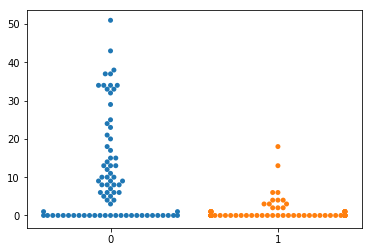

In [4]:
compiled_csv_dict = compile_csv_files(folder_name_str)
plot_quantification(compiled_csv_dict)